In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import torch
import multiprocessing
from src.toolkit import compute_dissimilarity
import DSA
import similarity
import pickle
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

### Get dynamics

In [3]:
curves_frozen = []
curves_frozen_names = []
curves_unfrozen = []
curves_unfrozen_names = []
explained_variances_frozen = []
explained_variances_unfrozen = []
dissimilarities = {"within_unfrozen": {}, "within_frozen": {}, "across": []}
for activation in config["rnn"]["parameters"]["activations"]:
    for hidden_size in config["rnn"]["parameters"]["n_rnn"]:
        for lr in config["rnn"]["parameters"]["learning_rate"]:
            for freeze in config["rnn"]["parameters"]["freeze"]:
                curve, explained_variance = compute_dissimilarity(
                    activation, hidden_size, lr, freeze, "cpu"
                )
                if freeze:
                    curves_frozen.append(curve)
                    curves_frozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_frozen.append(explained_variance)
                else:
                    curves_unfrozen.append(curve)
                    curves_unfrozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_unfrozen.append(explained_variance)




In [4]:
curve.shape

(100, 512, 3)

### Explained Variance Analysis

#### Frozen models

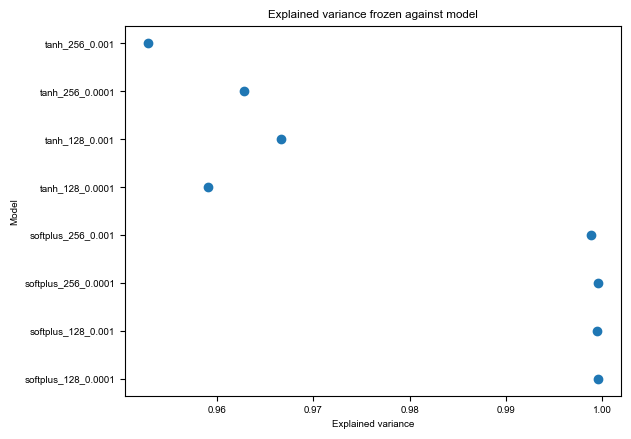

In [5]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_frozen, curves_frozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

#### Unfrozen models

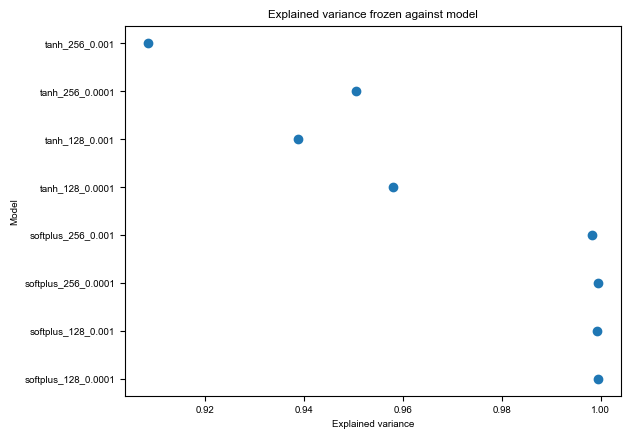

In [6]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_unfrozen, curves_unfrozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

### Visualize curves frozen

In [7]:
curves_frozen[0][:,0,:].shape

(100, 3)

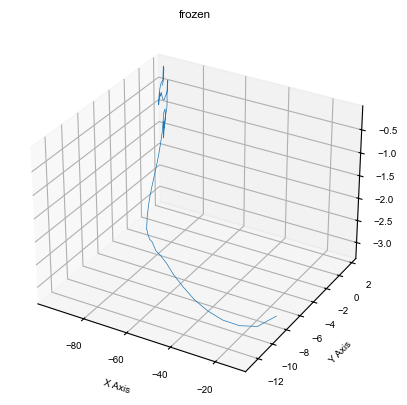

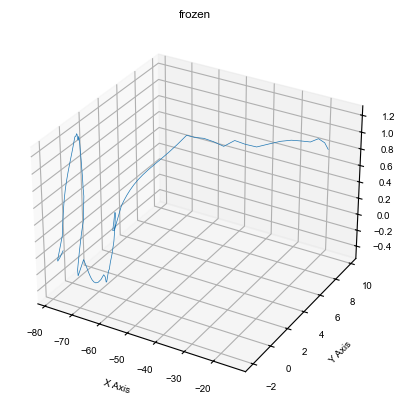

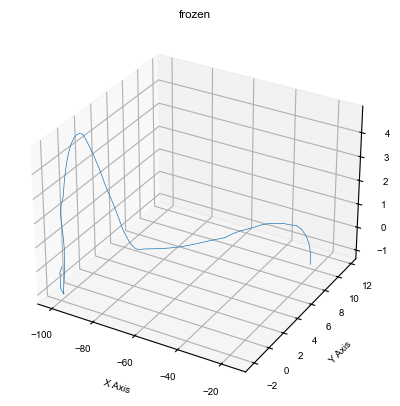

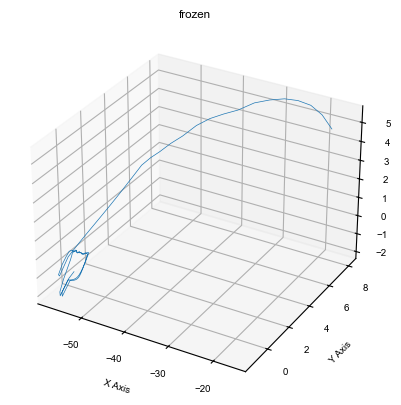

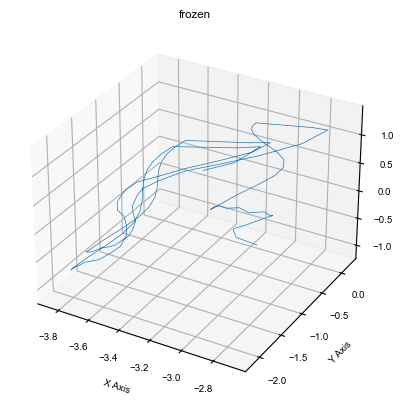

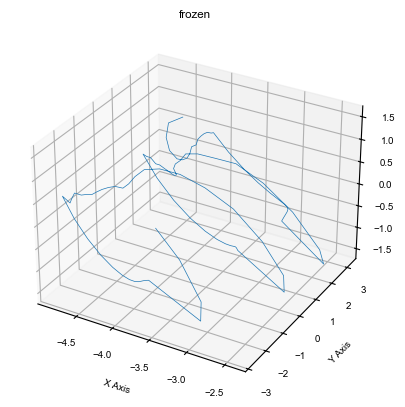

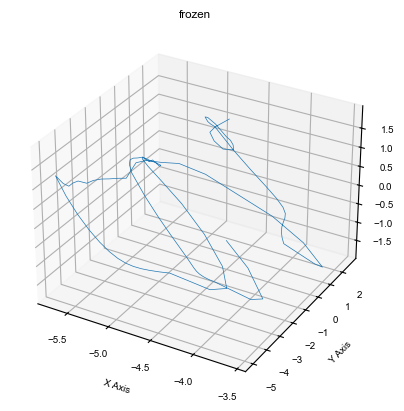

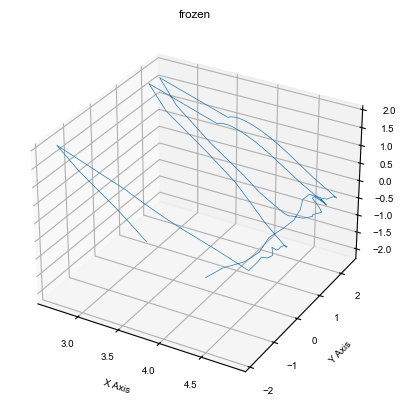

In [8]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves_frozen], f"frozen")

### Visualize curves unfrozen

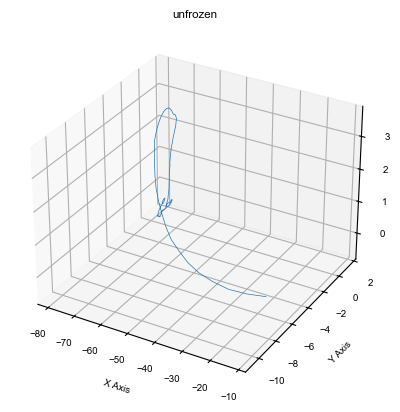

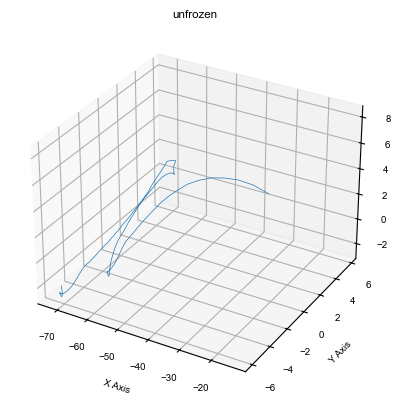

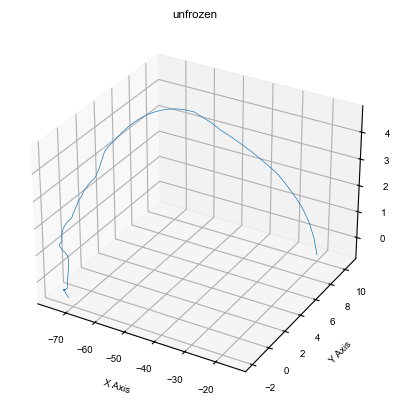

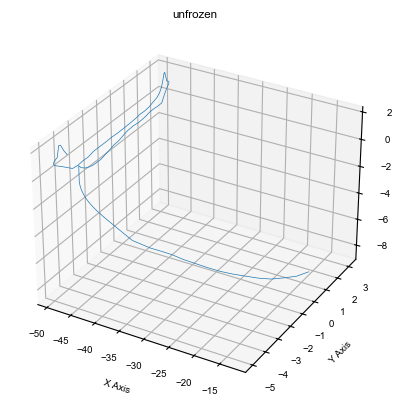

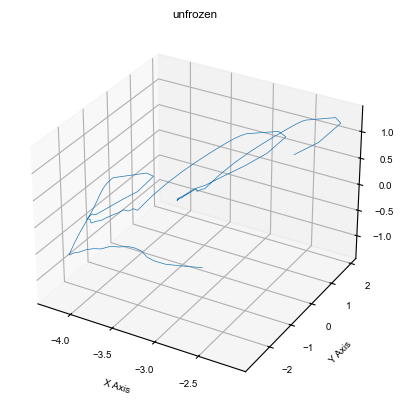

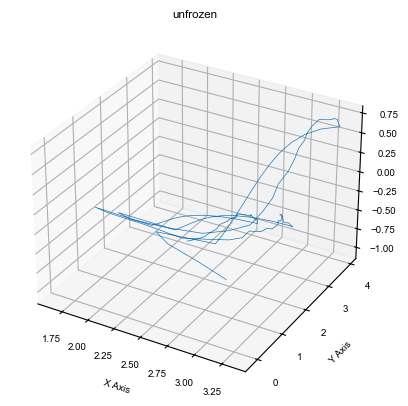

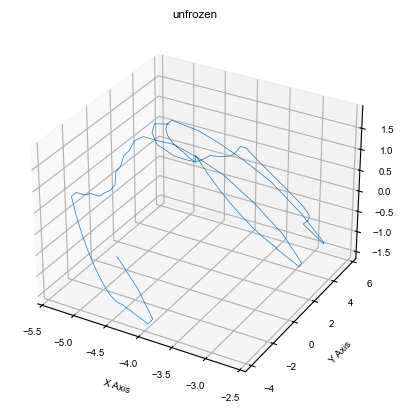

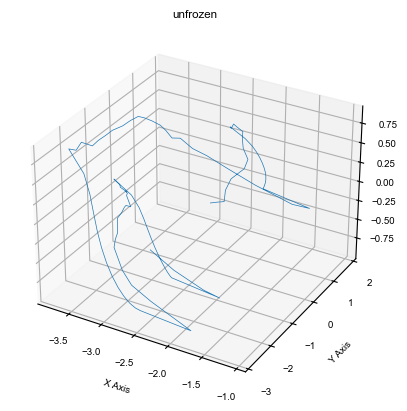

In [9]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves_unfrozen], f"unfrozen")

### Get dissimilarities

In [10]:
def measure_dissimilarities(group1, group2):
    cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
    procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
    dis_cka = np.empty((len(group1), len(group2)))
    dis_procrustes = np.empty((len(group1), len(group2)))
    for i, model1 in enumerate(group1):
        for j, model2 in enumerate(group2):
            dis_cka[i, j] = cka_measure(model1, model2)
            # test if nan otherwise replace by 1
            if np.isnan(dis_cka[i, j]):
                dis_cka[i, j] = 1
            dis_procrustes[i, j] = procrustes_measure(model1, model2)
    dsa_comp = DSA.DSA(
        group1, group2,
        n_delays=config["dsa"]["n_delays"],
        rank=config["dsa"]["rank"],
        delay_interval=config["dsa"]["delay_interval"],
        verbose=True,
        iters=1000,
        lr=1e-2,
    )
    dis_dsa = 1-dsa_comp.fit_score()
    return {"cka":dis_cka, "procrusts":dis_procrustes, "dsa":dis_dsa}

# dissimilarity within_frozen
dissimilarities["within_frozen"]= measure_dissimilarities(curves_frozen, curves_frozen)

# dissimilarity within_unfrozen
dissimilarities["within_unfrozen"]= measure_dissimilarities(curves_unfrozen, curves_unfrozen)

# dissimilarity across
dissimilarities["across"]= measure_dissimilarities(curves_frozen, curves_unfrozen)

arccos score: 1.0000000125715545 nan 1.2571554464102519e-08
arccos score: 0.9812350902609493 0.19403036959896225 0.01876490973905065
arccos score: 0.9860536841283702 0.16720558360176144 0.013946315871629755
arccos score: 0.8949231446464642 0.46253739011952416 0.10507685535353584
arccos score: 0.04492570832113463 1.5258554923277143 0.9550742916788654
arccos score: 0.035847909309997594 1.5349407351805109 0.9641520906900024
arccos score: 0.05937794035290711 1.5113834391054373 0.9406220596470929
arccos score: 0.05122777085665964 1.5195461233960115 0.9487722291433404
arccos score: 0.9812350902609493 0.19403036959896225 0.01876490973905065
arccos score: 1.0000000145341779 nan 1.453417786123623e-08
arccos score: 0.9742995747329983 0.22720594768030195 0.02570042526700167
arccos score: 0.8495071421101863 0.5557459279774887 0.1504928578898137
arccos score: 0.04431958051955054 1.526462224496247 0.9556804194804495
arccos score: 0.03657488232834272 1.534213285049606 0.9634251176716573
arccos score:

In [18]:
dissimilarities['across']['cka']

array([[0.92735211, 0.78367081, 0.91938911, 0.74539452, 0.01958703,
        0.00466001, 0.01774591, 0.00411548],
       [0.89036601, 0.79674723, 0.83879495, 0.69930938, 0.01962645,
        0.00491023, 0.01812639, 0.00416294],
       [0.86854225, 0.78249583, 0.86668573, 0.7037311 , 0.01690065,
        0.00434152, 0.01503269, 0.0034329 ],
       [0.69893522, 0.59758237, 0.71845826, 0.68112818, 0.02452338,
        0.00524447, 0.02294703, 0.00550214],
       [0.02880898, 0.02637041, 0.02784466, 0.03057692, 0.0186022 ,
        0.00710922, 0.01639363, 0.00762793],
       [0.02361335, 0.02165866, 0.02245026, 0.02486426, 0.01965055,
        0.00762987, 0.01733711, 0.00747473],
       [0.03809708, 0.03501144, 0.03709213, 0.04119463, 0.02471438,
        0.00959406, 0.02121034, 0.00907864],
       [0.03384213, 0.03109324, 0.03245471, 0.03499877, 0.02043783,
        0.00789997, 0.02079818, 0.0078546 ]])

### Plot dissimilarities within and across groups

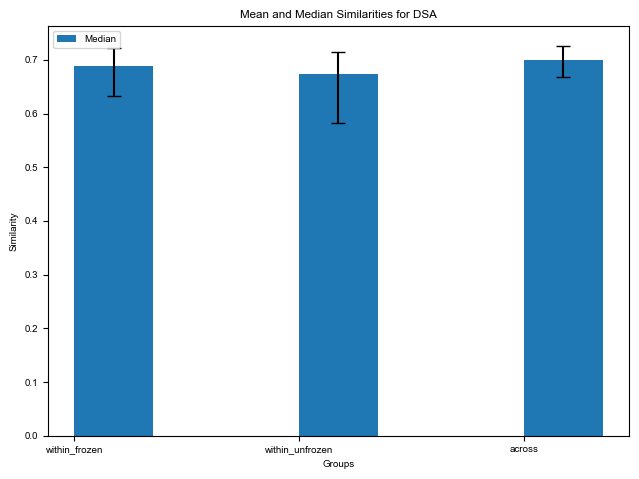

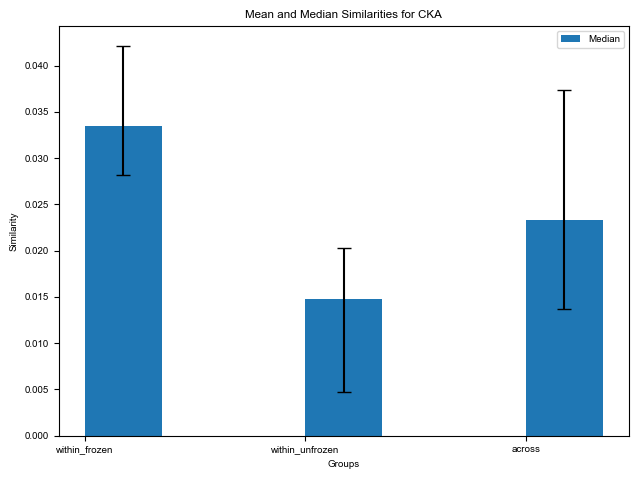

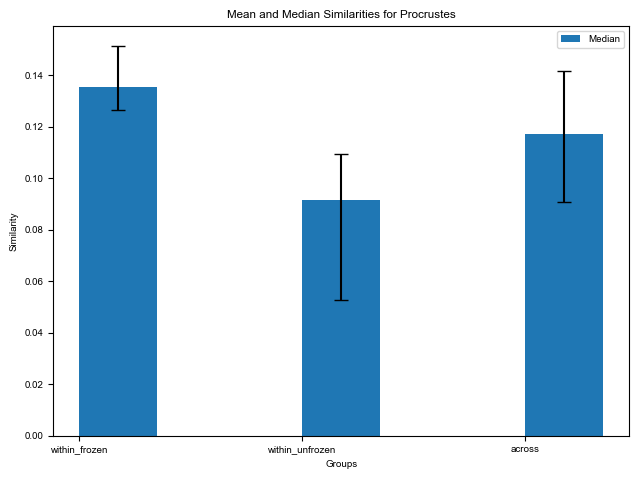

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}
    for group in ["within_frozen", "within_unfrozen", "across"]:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "mean": np.mean(dis_values),
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")


# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")

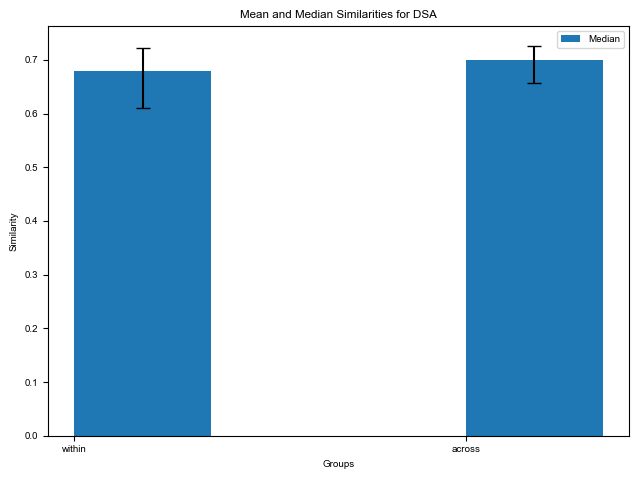

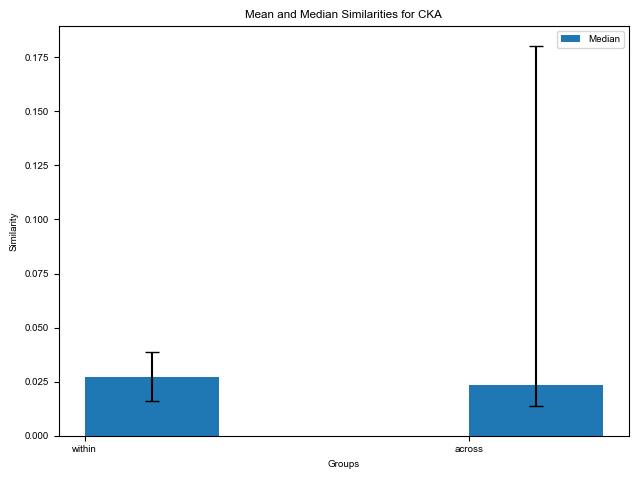

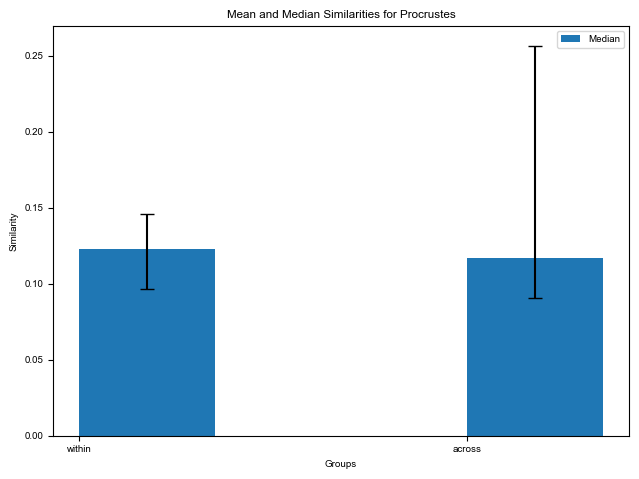

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}

    # Combine within_frozen and within_unfrozen into a single 'within' group
    dis_within = np.concatenate(
        [
            dissimilarities["within_frozen"][measure][
                ~np.eye(dissimilarities["within_frozen"][measure].shape[0], dtype=bool)
            ],
            dissimilarities["within_unfrozen"][measure][
                ~np.eye(
                    dissimilarities["within_unfrozen"][measure].shape[0], dtype=bool
                )
            ],
        ]
    )

    dis_across = dissimilarities["across"][measure]

    stats["within"] = {
        "mean": np.mean(dis_within),
        "median": np.median(dis_within),
        "q1": np.percentile(dis_within, 25),
        "q3": np.percentile(dis_within, 75),
    }

    stats["across"] = {
        "mean": np.mean(dis_across),
        "median": np.median(dis_across),
        "q1": np.percentile(dis_across, 25),
        "q3": np.percentile(dis_across, 75),
    }

    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")


# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")
